In [1]:
import warnings
import matplotlib.pyplot as plt
import ngflowboost as ngbf
import numpy as np
import torch

from models.flow import build_model

warnings.filterwarnings('ignore')

In [2]:
def _generate_data(n=100, std=0.1):
    eps = std * np.random.randn(n)
    x = np.random.rand(n) * 4*np.pi - 2*np.pi
    y = np.sin(x) + eps
    return x, y


def generate_data(n=100, std=0.1):
    x1, y1 = _generate_data(n=n, std=std)
    x2, y2 = _generate_data(n=n, std=std)
    y2 = -y2
    return np.concatenate([x1, x2]).reshape(-1, 1), np.concatenate([y1, y2])

In [3]:
x, y = generate_data(n=300, std=0.1)

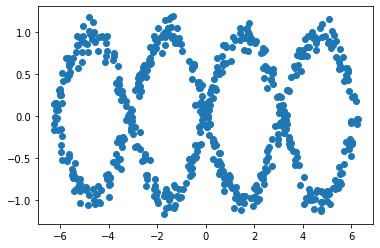

In [4]:
plt.scatter(x, y)
plt.show()

In [5]:
flow = build_model(
    input_dim=1,
    hidden_dims=(40,40,40,),
    context_dim=1,
    conditional=True,
    time_length=1.0,
    batch_norm=True,
    layer_type="concatscale"
)

model = ngbf.NGBoost(verbose_eval=25, flow=flow)

In [6]:
model.fit(x, y)

Loss 0.83: 100%|██████████| 100/100 [00:51<00:00,  1.92it/s]


[iter 0] loss=0.7876 val_loss=0.0000 scale=512.0000 norm=0.4083
[iter 25] loss=0.7584 val_loss=0.0000 scale=512.0000 norm=0.4235
[iter 50] loss=0.6992 val_loss=0.0000 scale=512.0000 norm=0.4181
[iter 75] loss=0.5485 val_loss=0.0000 scale=512.0000 norm=0.4306
[iter 100] loss=0.4348 val_loss=0.0000 scale=512.0000 norm=0.3833
[iter 125] loss=0.2660 val_loss=0.0000 scale=512.0000 norm=0.3870
[iter 150] loss=0.0865 val_loss=0.0000 scale=512.0000 norm=0.4146
[iter 175] loss=0.0732 val_loss=0.0000 scale=512.0000 norm=0.4273
[iter 200] loss=0.0843 val_loss=0.0000 scale=512.0000 norm=0.3892
[iter 225] loss=0.0378 val_loss=0.0000 scale=512.0000 norm=0.4098
[iter 250] loss=-0.1087 val_loss=0.0000 scale=128.0000 norm=0.1136
[iter 275] loss=-0.0067 val_loss=0.0000 scale=512.0000 norm=0.3980
[iter 300] loss=-0.0785 val_loss=0.0000 scale=512.0000 norm=0.3975
[iter 325] loss=-0.0010 val_loss=0.0000 scale=0.5000 norm=0.0004
[iter 350] loss=0.0247 val_loss=0.0000 scale=512.0000 norm=0.4190
== Quitting a

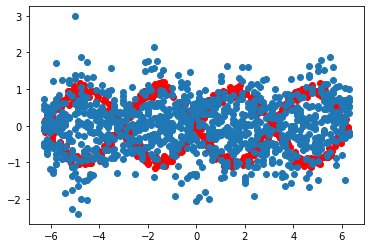

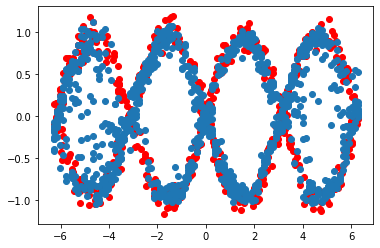

In [7]:
DEVICE = model.DEVICE
n_samples = 10

# x, y = generate_data(std=0.01)

x_new = torch.linspace(-2*np.pi, 2*np.pi, 101).repeat(n_samples).reshape(-1, 1)
y_params = model.pred_param(x_new)
y_samples = model.pred_dist(x_new).sample(1)

# plt.errorbar(x_new, y_params[:, 0], yerr=np.exp(y_params[:, 1]), fmt='o')
plt.scatter(x, y, c='red')
plt.scatter(x_new, y_samples)
plt.show()

x_new = x_new.to(DEVICE)
y_params = torch.Tensor(y_params).to(DEVICE)
z = torch.randn(len(x_new), 1).to(DEVICE)
z = (z + y_params[:, 0].reshape(-1, 1)) * y_params[:, 1].exp().reshape(-1, 1)

y_new = model.flow(x=z, context=x_new, reverse=True)
y_new = y_new.detach().cpu().numpy()

plt.scatter(x, y, c='red')
plt.scatter(x_new.detach().cpu().numpy(), y_new)
plt.show()

In [8]:
from math import log, pi

def gaussian_log_likelihood(x, mean, logvar, clip=True):
    if clip:
        logvar = torch.clamp(logvar, min=-4, max=3)
    a = log(2 * pi)
    b = logvar
    c = (x - mean) ** 2 / torch.exp(logvar)
    return -0.5 * (a + b + c)

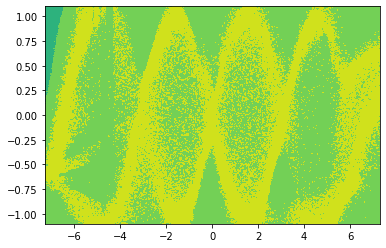

In [12]:
x_new, y_new = np.meshgrid(
    np.linspace(-2*np.pi - 1.0, 2*np.pi + 1.0, 500),
    np.linspace(-1.1, 1.1, 500)
)

x = torch.Tensor(y_new.reshape(-1, 1)).to(DEVICE)
context = torch.Tensor(x_new.reshape(-1)).to(DEVICE)
params = torch.Tensor(model.pred_param(x_new.reshape(-1, 1))).to(DEVICE)
mean, logvar = params[:, 0].reshape(-1, 1), params[:, 1].reshape(-1, 1)
zero = torch.zeros(np.prod(x_new.shape), 1).to(DEVICE)

            
z, delta_logp = model.flow(
    x=x, 
    context=context, 
    logpx=zero,
    reverse=False
)


logpz = gaussian_log_likelihood(z, mean=mean, logvar=logvar)
logpx = logpz - delta_logp
logpx = logpx.detach().cpu().numpy()

plt.contourf(x_new, y_new, logpx.reshape(*x_new.shape))
plt.show()